In [1]:
!pip install patchify

In [2]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
from patchify import patchify
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
root_directory = '/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset'
# root_directory
patch_size = 256
scaler = MinMaxScaler()

In [4]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        image_files = sorted([image_name for image_name in images if image_name.endswith(".jpg")])

        for image_name in image_files:
            image = cv2.imread(path + "/" + image_name, 1)
            SIZE_X = (image.shape[1] // patch_size) * patch_size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)

            print("Now patchifying image:", path + "/" + image_name)
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i, j, :, :]
                    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                    single_patch_img = single_patch_img[0]
                    image_dataset.append(single_patch_img)


Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_001.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_002.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_003.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_004.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_005.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_006.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_007.jpg
Now patchifying imag

In [5]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        mask_files = sorted([mask_name for mask_name in masks if mask_name.endswith(".png")])
        for mask_name in mask_files:
                mask = cv2.imread(path+"/"+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                print("Now patchifying mask:", path + "/" + mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step = patch_size)
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]                            
                        mask_dataset.append(single_patch_mask)

Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_001.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_002.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_003.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_004.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_005.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_006.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_007.png
Now patchifying mask: /kaggle/inpu

In [6]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [7]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

In [8]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0] 
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


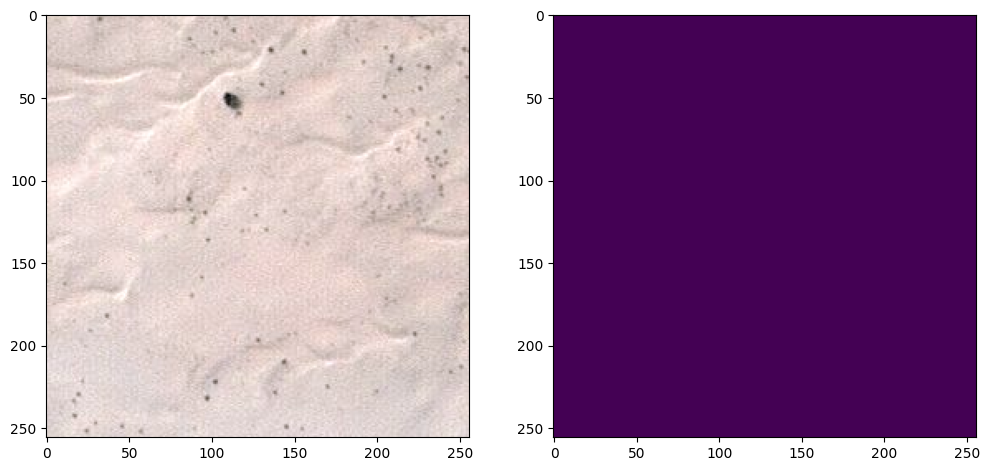

In [9]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [10]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [12]:
# print(X_train.shape)
n_classes = 6
height = X_train.shape[1]
width = X_train.shape[2]
n_channels = X_train.shape[3]
input_shape = (height, width, n_channels)

In [13]:
# Non_bottleneck_1D Block
def non_bottleneck_1D(x, filters, strides=(1, 1), dilation = 1):
    residual = x
    # print(residual.shape)

    x = tf.keras.layers.Conv2D(filters, (3, 1), strides=strides, padding = 'same')(x) #activation = 'relu'
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, (1, 3), strides=strides, padding = 'same')(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, (3, 1), strides=strides, padding = 'same')(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, (1, 3), strides=strides, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # print(x.shape)
    x = tf.keras.layers.Add()([x, residual])
    x = tf.keras.layers.ReLU()(x)
    return x


def ERFNet(n_classes, height, width):
    input_tensor = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    for _ in range(5):
        x = non_bottleneck_1D(x, 64)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    for _ in range(2):
        x = non_bottleneck_1D(x, 128, dilation=2)
        x = non_bottleneck_1D(x, 128, dilation=4)
        x = non_bottleneck_1D(x, 128, dilation=8)
        x = non_bottleneck_1D(x, 128, dilation=16)

    # Decoder
    # print(x.shape, "1")
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides = (2,2), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # print(x.shape, "2")
    for _ in range(2):
        x = non_bottleneck_1D(x, 64)
    # print(x.shape, "3")

    x = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides = (2,2), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # print(x.shape, "4")

    for _ in range(2):
        x = non_bottleneck_1D(x, 16)

    # print(x.shape)
    x = tf.keras.layers.Conv2DTranspose(n_classes, (2,2), strides = (2,2), activation = 'softmax')(x)
    # print(x.shape)
    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model

In [14]:
erfnet_model = ERFNet(n_classes, height, width)

In [15]:
erfnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [16]:
erfnet_model.compile(optimizer = tf.keras.optimizers.Adam(0.01), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = tf.keras.metrics.BinaryAccuracy())

In [17]:
callbacks=[tf.keras.callbacks.ModelCheckpoint('aerial_modelcheckpoint.h5',verbose=1,save_best_only=True),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=False,patience=20)]
model_history = erfnet_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 16, epochs=20, shuffle = False, callbacks=callbacks)

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 1.2077 - binary_accuracy: 0.8812
Epoch 1: val_loss improved from inf to 13707604.00000, saving model to aerial_modelcheckpoint.h5
66/66 [==============================] - 67s 275ms/step - loss: 1.2077 - binary_accuracy: 0.8812 - val_loss: 13707604.0000 - val_binary_accuracy: 0.7070
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.9368 - binary_accuracy: 0.9019
Epoch 2: val_loss improved from 13707604.00000 to 2850.41479, saving model to aerial_modelcheckpoint.h5
66/66 [==============================] - 15s 220ms/step - loss: 0.9368 - binary_accuracy: 0.9019 - val_loss: 2850.4148 - val_binary_accuracy: 0.7289
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.9065 - binary_accuracy: 0.9042
Epoch 3: val_loss improved from 2850.41479 to 671.08215, saving model to aerial_modelcheckpoint.h5
66/66 [==============================] - 15s 222ms/step - loss: 0.9065 - binary_accuracy: 0.904

In [18]:
erfnet_model.save("ERFNet")

In [19]:
y_pred=erfnet_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

9/9 [==============================] - 3s 95ms/step
Mean IoU = 0.25437686


1/1 [==============================] - 0s 287ms/step


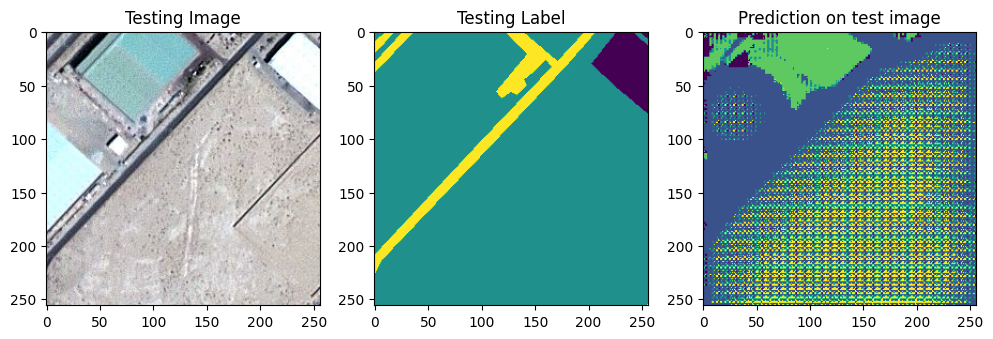

In [20]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (erfnet_model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()
